M3. Improve BoVW with SVM's
--

In [1]:
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from utils.CodeTimer import CodeTimer
from utils.DatasetManager import DatasetManager
from descriptors.SIFT import DenseSIFT as DenseSIFT_
from descriptors.SIFT import DenseSIFTPyramid as DenseSIFTPyramid_
from descriptors.VisualWords import VisualWords as VisualWords_
from descriptors.VisualWords import VisualWordsPyramid as VisualWordsPyramid_
from utils.Kernels import histogram_intersection_kernel

In [10]:
dataset = DatasetManager(r"C:\Users\PC\Documents\Roger\Master\M3\Project\Databases\MIT_split")
train_img_paths, train_labels, test_img_paths, test_labels = dataset.load_dataset()
SAVE_PATH = r"C:\Users\PC\Documents\Roger\Master\M3\Project\GIT\Week2\SavePath"

Scale the data and try a pyramidal scheme
--

Here we use the parameters that provided the best results until the moment.

In [12]:
STEP_SIZE = 16
DESC_SIZE = [8,16]
N_CLUSTERS = [128, 256, 384, 512, 640, 768, 896, 1024]
K_FOLDS = 5
param_grid = {'C': [1], 'kernel': [histogram_intersection_kernel], 'gamma': ['scale']}
results_test = []
results_train = []

DenseSIFTPyramid = DenseSIFTPyramid_()
scaler = StandardScaler()
for n_cluster in N_CLUSTERS:
    VisualWordsPyramid = VisualWordsPyramid_(n_cluster)
    train_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_desc_path = SAVE_PATH+os.sep+'desc'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    train_data_path = SAVE_PATH+os.sep+'data'+os.sep+'train'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    test_data_path = SAVE_PATH+os.sep+'data'+os.sep+'test'+str(n_cluster)+'_'+str(STEP_SIZE)+'_8-16.dat'
    if all(os.path.isfile(path) for path in [train_desc_path,test_desc_path,train_data_path,test_data_path]):
        train_desc = pickle.load(open(train_desc_path, 'rb'))
        test_desc = pickle.load(open(test_desc_path,'rb'))
        train_data = pickle.load(open(train_data_path,'rb'))
        test_data = pickle.load(open(test_data_path,'rb'))
    else:
        with CodeTimer("Obtain training and test data"):
            # Compute DenseSIFT descriptors for train and test sets
            train_desc = DenseSIFTPyramid.compute(train_img_paths, STEP_SIZE, DESC_SIZE, 2)
            test_desc = DenseSIFTPyramid.compute(test_img_paths, STEP_SIZE, DESC_SIZE, 2)
            # Save computed data
            pickle.dump(train_desc, open(train_desc_path, 'wb'))
            pickle.dump(test_desc, open(test_desc_path, 'wb'))
            # Obtain visual words for train and test sets
            VisualWordsPyramid.fit(train_desc)
            train_data = VisualWordsPyramid.get_visual_words(train_desc)
            test_data = VisualWordsPyramid.get_visual_words(test_desc)
            # Save computed data
            pickle.dump(train_data, open(train_data_path, 'wb'))
            pickle.dump(test_data, open(test_data_path, 'wb'))
    # Scale data
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # Train SVM with cross-validation 5-fold
    with CodeTimer("Train SVM"):
        cv = GridSearchCV(SVC(), param_grid=param_grid, cv=K_FOLDS)
        cv.fit(train_data, train_labels)
    # Test SVM
    with CodeTimer("Test SVM"):
        results_train.append(cv.score(train_data, train_labels)) 
        results_test.append(cv.score(test_data, test_labels)) 

Obtain training and test data: 600.8334321975708 s
Train SVM: 109.06886768341064 s
Test SVM: 32.245548486709595 s
Obtain training and test data: 609.0359482765198 s
Train SVM: 193.56341743469238 s
Test SVM: 54.376542806625366 s
Obtain training and test data: 665.2286114692688 s
Train SVM: 267.89624285697937 s
Test SVM: 77.6819281578064 s
Obtain training and test data: 692.5553328990936 s
Train SVM: 349.1913044452667 s
Test SVM: 98.74928569793701 s
Obtain training and test data: 804.787700176239 s
Train SVM: 499.9225287437439 s
Test SVM: 150.77769708633423 s
Obtain training and test data: 1134.888260126114 s
Train SVM: 636.0088942050934 s
Test SVM: 184.2158064842224 s
Obtain training and test data: 1260.281283378601 s
Train SVM: 730.613344669342 s
Test SVM: 182.11422085762024 s
Obtain training and test data: 1219.0165905952454 s
Train SVM: 670.5159146785736 s
Test SVM: 207.78632283210754 s


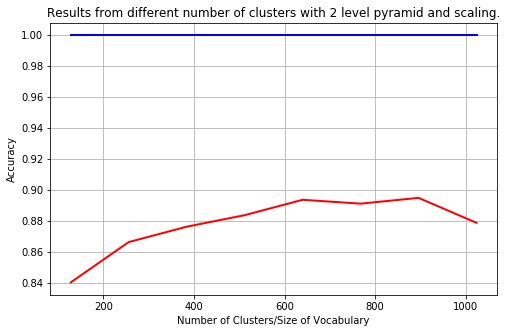

In [13]:
plt.figure(figsize=(8, 5))
plt.title('Results from different number of clusters with 2 level pyramid and scaling.')
plt.plot(N_CLUSTERS,results_train,'b',linewidth=2,label='Test')
plt.plot(N_CLUSTERS,results_test,'r',linewidth=2,label='Train')
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters/Size of Vocabulary')
plt.grid(True)
plt.show()

In [14]:
print(results_train)
print(results_test)

[0.9994683678894205, 0.9994683678894205, 0.9994683678894205, 0.9994683678894205, 0.9994683678894205, 0.9994683678894205, 0.9994683678894205, 0.9994683678894205]
[0.8401486988847584, 0.8661710037174721, 0.8760842627013631, 0.8835192069392813, 0.8934324659231723, 0.8909541511771994, 0.8946716232961586, 0.8785625774473358]


We can observe that using 896 clusters provides the best results after using scaling and a 2-level pyramid.